In [5]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import MNIST
from torchvision.utils import make_grid as make_image_grid
from torchvision import datasets, transforms
from tqdm import tnrange
from torch.optim.lr_scheduler import MultiStepLR

sns.set_style('dark')
%matplotlib inline

In [6]:
class Encoder(nn.Module):
    def __init__(self, latent_dim = 2, hidden_dim = 500):
        super(Encoder,self).__init__()
        self.enc_L1 = nn.Linear(784,hidden_dim)
        self.enc_mean = nn.Linear(hidden_dim,latent_dim)
        self.enc_logvar = nn.Linear(hidden_dim,latent_dim)  
        
    def forward(self, x):
        x = F.relu(self.enc_L1(x.view(-1,784)))
        mean = self.enc_mean(x)
        logvar = self.enc_logvar(x)
        return mean, logvar

In [7]:
class Decoder(nn.Module):
    def __init__(self, latent_dim = 2, hidden_dim = 500):
        super(Decoder,self).__init__()
        self.dec_L1 = nn.Linear(latent_dim,hidden_dim)
        self.dec_L2 = nn.Linear(hidden_dim,784) 
        
    def forward(self, z):
        z = F.relu(self.dec_L1(z))
        gen_data = F.sigmoid(self.dec_L2(z))
        return gen_data.view(-1,1,28,28)

In [8]:
# Model
class VAE(nn.Module):
    def __init__(self,latent_dim=20,hidden_dim=500):
        super(VAE,self).__init__()
        self.encoder = Encoder(latent_dim, hidden_dim)
        self.decoder = Decoder(latent_dim, hidden_dim)
    
    def reparameterize(self,mean,logvar):
        sd = torch.exp(logvar*0.5)
        e = Variable(sd.data.new(sd.size()).normal_()) 
        z = e.mul(sd).add_(mean)
        return z
    
    def forward(self,x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean,logvar)
        return self.decoder(z), mean, logvar


In [9]:
class Discriminator(nn.Module):
    def __init__(self, hidden_dim = 20):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Linear(latent_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()

    def forward(self,x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        return F.sigmoid(self.layer3(x))

In [10]:
# Loss function for VAEs
def rec_loss_function(gen_data, real_data,mean,logvar):
    BCE = F.binary_cross_entropy(gen_data, real_data, size_average = False)
    KL = -0.5 * torch.sum(1 + logvar - (mean ** 2) - torch.exp(logvar))
    loss = (BCE + KL) / gen_data.size(0)
    return loss

In [11]:
# Loss function for AAEs
def rec_loss_function_AAE(gen_data, real_data):
    BCE = F.binary_cross_entropy(gen_data, real_data, size_average = False)
    return BCE / gen_data.size(0)

In [12]:
batch_size = 100
cuda = True
latent_dim = 2
train_interval = 100
hidden_dim = 500
train_dataset = datasets.MNIST(root='./data/',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)
test_dataset = datasets.MNIST(root='./data/',
                           train=False,
                           transform=transforms.ToTensor())
torch.manual_seed(3435)
train_img = torch.stack([torch.bernoulli(d[0]) for d in train_dataset])
train_label = torch.LongTensor([d[1] for d in train_dataset])
test_img = torch.stack([torch.bernoulli(d[0]) for d in test_dataset])
test_label = torch.LongTensor([d[1] for d in test_dataset])
val_img = train_img[-10000:].clone()
val_label = train_label[-10000:].clone()
train_img = train_img[:-10000]
train_label = train_label[:-10000]
train_set = torch.utils.data.TensorDataset(train_img, train_label)
val_set = torch.utils.data.TensorDataset(val_img, val_label)
test_set = torch.utils.data.TensorDataset(test_img, test_label)
kwargs = {'num_workers': 1, 'pin_memory': True} 
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, **kwargs)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, **kwargs)


In [13]:
def validate(model,dataloader):
    valid_loss = 0.0
    for images, _ in dataloader:
        real_data = Variable(images).cuda()
        gen_data, mean, logvar = model(real_data)
        loss = rec_loss_function(gen_data,real_data, mean, logvar)
        valid_loss = valid_loss + (loss.data[0]*real_data.size(0))
    return valid_loss/len(dataloader.dataset)

In [24]:
# Training
def train(model,optimizer,dataloader,epochs=15):
    losses = []
    for epoch in tnrange(epochs,desc='Epochs'):
        for images,_ in dataloader:
            real_data = Variable(images).cuda()
            optimizer.zero_grad()
            gen_data, mean, logvar = model(real_data)
            loss = rec_loss_function(gen_data,real_data,mean,logvar)
            loss.backward()
            optimizer.step()
        losses.append(validate(model, val_loader))
        if epoch %5 == 0:
            visualize_random_sample(model, dataloader, num=4)
    return losses



In [66]:
# Visualize test data encodings on the latent space
def visualize_encoder(model,dataloader):
    z_means_x, z_means_y, all_labels = [], [], []
    
    for images,labels in iter(dataloader):
        z_means,_ = model.encoder(Variable(images).cuda())
        z_means = z_means.cpu()
        z_means_x = np.append(z_means_x,z_means[:,0].data.numpy())
        z_means_y = np.append(z_means_y,z_means[:,1].data.numpy())
        all_labels = np.append(all_labels,labels.numpy())
        
    plt.figure(figsize=(6.5,5))
    plt.scatter(z_means_x,z_means_y,c=all_labels)
    plt.colorbar()
    plt.show()

In [ ]:
# For checking autoencoders (from https://github.com/nitarshan/variational-autoencoder/blob/master/Variational%20Autoencoder%20Tutorial.ipynb)
def visualize_mnist_vae(model,dataloader,num=4):
    def imshow(img):
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg,(1,2,0)))
        plt.axis('off')
        plt.show()
        
    images,_ = iter(dataloader).next()
    images = images[0:num,:,:]
    x_in = Variable(images).cuda()
    x_out,_,_ = model(x_in)
    x_out = x_out.data.cpu()
    imshow(make_image_grid(images))
    imshow(make_image_grid(x_out))

In [19]:
# Generate a bunch of digits from your generative model
def visualize_random_sample(model,dataloader,num=16):
    sample = Variable(torch.randn(num, latent_dim)).cuda()
    gen_batch = model.decoder(sample)
    sample = gen_batch.cpu().data
    output_image = make_image_grid(sample).numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(output_image,(1,2,0)))
    plt.axis('off')
    plt.show()

In [16]:
# Generate a bunch of digits from your generative model
def visualize_interpolated_samples(model,dataloader):
    sample1 = Variable(torch.randn(1, latent_dim)).cuda()
    sample2 = Variable(torch.randn(1, latent_dim)).cuda()
    
    for i, alpha in enumerate([0, 0.2, 0.4, 0.5, 0.8, 1.0]):
        plt.subplot(1,6,i+1)
        interpolation = alpha* sample1 + (1-alpha) * sample2
        gen_batch = model.decoder(interpolation)
        sample = gen_batch.cpu().data
        output_image = make_image_grid(sample).numpy()
        plt.imshow(np.transpose(output_image,(1,2,0)))
        plt.axis('off')
    plt.show()
    

In [69]:
# Visualize digits generated from latent space grid
def visualize_decoder(model,num=10):
    image_grid = np.zeros([num*28,num*28])

    for i, x in enumerate(np.linspace(-2, 2, 10)):
        for j, y in enumerate(reversed(np.linspace(-2, 2, 10))):
            z = Variable(torch.FloatTensor([[x,y]])).cuda()
            image = model.decoder(z)
            image = image.cpu()
            image = image.data.numpy()
            image_grid[(j*28):((j+1)*28),(i*28):((i+1)*28)] = image
    plt.figure(figsize=(10, 10))
    plt.imshow(image_grid, cmap='Greys')
    plt.show()

In [60]:
def train_AAE(model,discrim, aae_optimizer, enc_optimizer, dis_optimizer,aae_scheduler,  dataloader,epochs=200):
    losses = []
    d_loss = nn.BCELoss(size_average=False)
    for epoch in tnrange(epochs,desc='Epochs'):
        aae_scheduler.step()
        batches = 0
        total_gen_loss = 0
        total_disc_loss = 0
        correct = 0
        train_loss = 0
        for images,_ in dataloader:
            for p in discrim.parameters():
                p.requires_grad = False
            # Step for Autoencoders
            real_data = Variable(images).cuda()
            aae_optimizer.zero_grad()
            enc_optimizer.zero_grad()
            dis_optimizer.zero_grad()
            gen_data, mean, logvar = model(real_data)
            if epoch <= pre_train:
                loss = rec_loss_function(gen_data,real_data, mean, logvar)
            else:
                loss = rec_loss_function_AAE(gen_data,real_data)
            loss.backward()
            aae_optimizer.step()
            train_loss += loss.data[0]
            
            if epoch > pre_train:
                exs = images.size()[0]
                for p in discrim.parameters():
                    p.requires_grad = True            
                dis_optimizer.zero_grad()
                z_real_gauss = Variable(torch.randn(batch_size, latent_dim)).cuda()
                mean, logvar = model.encoder(real_data)
                z_generated = model.reparameterize(mean, logvar)
                #labels
                z_real = Variable(torch.ones(exs)).cuda()
                z_fake = Variable(torch.zeros(exs)).cuda()
                z_hat_real = discrim(z_real_gauss)
                z_hat_fake = discrim(z_generated)

                real_loss = d_loss(z_hat_real.squeeze(),z_real)
                fake_loss = d_loss(z_hat_fake.squeeze(),z_fake)
                correct += int(torch.sum(z_hat_fake.lt(0.5)))
                #step for discriminator
                disc_loss = real_loss + fake_loss
                total_disc_loss += disc_loss
                disc_loss.backward()
                dis_optimizer.step()
                mean_2, logvar_2 = model.encoder(real_data)
                z_generated_2 = model.reparameterize(mean_2, logvar_2)
                z_hat_fake_2 = discrim(z_generated_2)
                gen_loss = d_loss(z_hat_fake_2.squeeze(), z_real)
                total_gen_loss += gen_loss
                enc_optimizer.zero_grad()
                gen_loss.backward()
                enc_optimizer.step()
        losses.append(validate_AAE(model, val_loader))
        total_gen_loss /= float(len(dataloader) * len(images))
        total_disc_loss /= float(len(dataloader) * len(images) * 2)
        acc = float(correct) / float((len(dataloader) * len(images)))
        if epoch % 5 == 0:
            print("Epoch %d: Gen CE loss: %.2f Disc CE loss %.2f Disc acc: %.3f Correct: %d Valid Loss: %.2f" % (epoch, total_gen_loss, total_disc_loss, acc, correct, losses[-1]))
            print('Sample Z')
            visualize_random_sample(model_aae,test_loader, num=4)
            print('Real input')
            visualize_mnist_vae(model_aae, test_loader, num=4)
            
    return losses


In [56]:
def validate_AAE(model,dataloader):
    valid_loss = 0.0
    for images, _ in dataloader:
        real_data = Variable(images).cuda()
        gen_data, _, _ = model(real_data)
        loss = rec_loss_function_AAE(gen_data,real_data)
        valid_loss = valid_loss + (loss.data[0]*real_data.size(0))
    return valid_loss/len(dataloader.dataset)

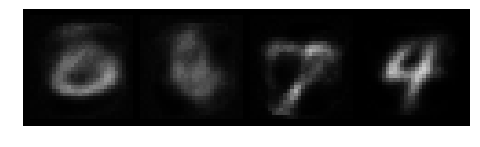

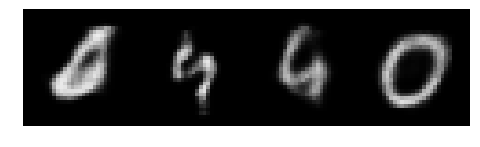

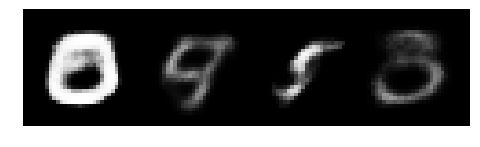

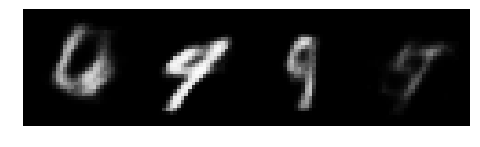

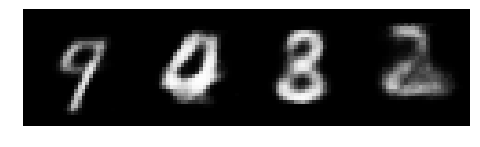

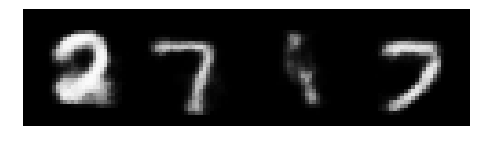

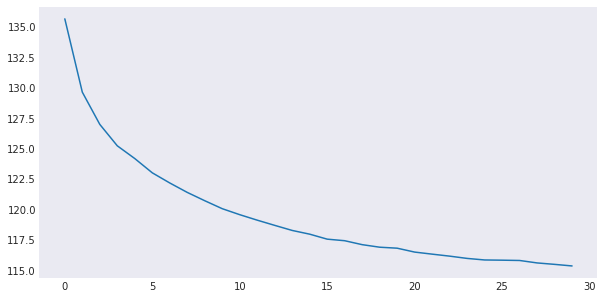

In [32]:
batch_size = 100
cuda = True
latent_dim = 6
train_interval = 100
hidden_dim = 1000

model = VAE(latent_dim = latent_dim, hidden_dim = hidden_dim)
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = 5e-4)
train_losses = train(model,optimizer,train_loader, epochs=30)
plt.figure(figsize=(10,5))
plt.plot(train_losses)
plt.show()

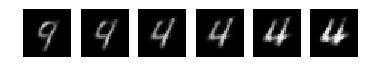

In [35]:
visualize_interpolated_samples(model,val_loader)

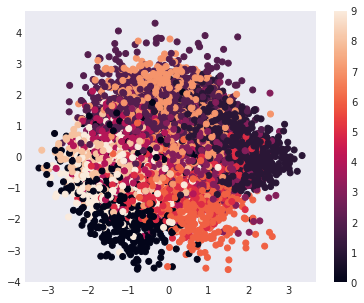

In [36]:
visualize_encoder(model,test_loader)

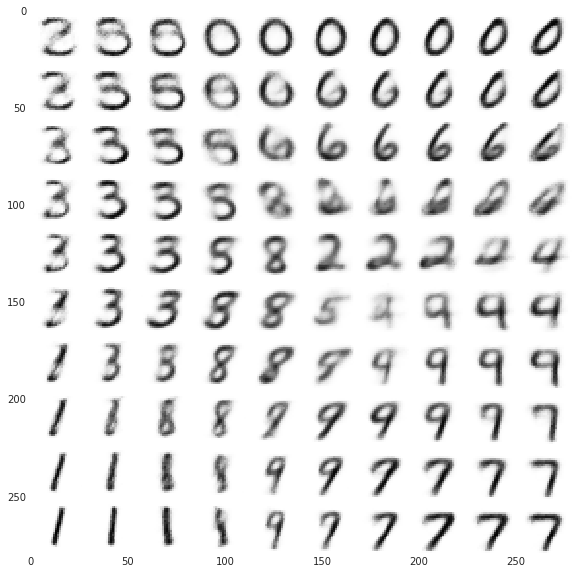

In [87]:


visualize_decoder(model)

Epoch 0: Gen CE loss: 0.00 Disc CE loss 0.00 Disc acc: 0.000 Correct: 0 Valid Loss: 119.25
Sample Z


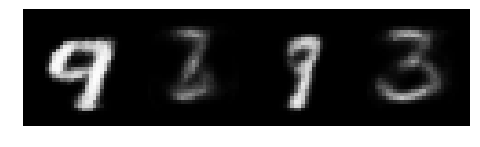

Real input


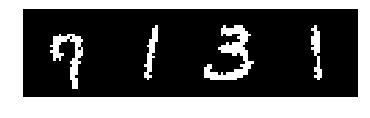

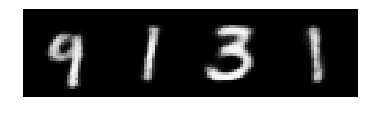

Epoch 5: Gen CE loss: 0.78 Disc CE loss 0.64 Disc acc: 0.646 Correct: 32320 Valid Loss: 110.08
Sample Z


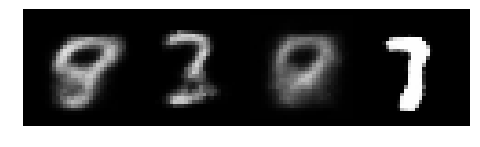

Real input


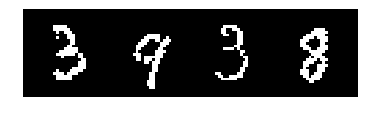

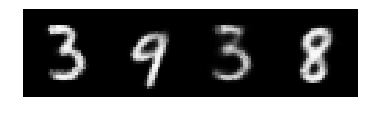

Epoch 10: Gen CE loss: 1.01 Disc CE loss 0.57 Disc acc: 0.749 Correct: 37436 Valid Loss: 107.40
Sample Z


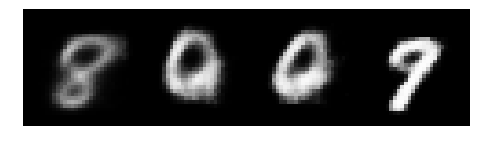

Real input


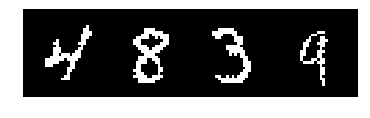

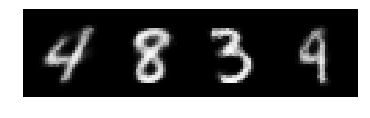

Epoch 15: Gen CE loss: 1.06 Disc CE loss 0.56 Disc acc: 0.753 Correct: 37645 Valid Loss: 106.74
Sample Z


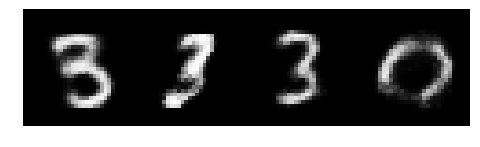

Real input


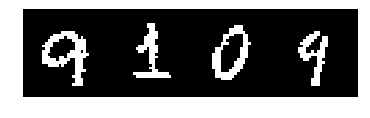

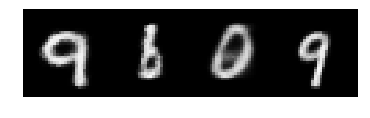

Epoch 20: Gen CE loss: 1.09 Disc CE loss 0.56 Disc acc: 0.759 Correct: 37931 Valid Loss: 107.50
Sample Z


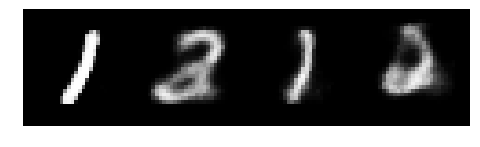

Real input


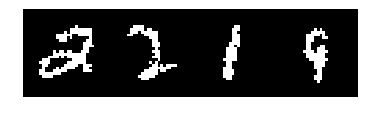

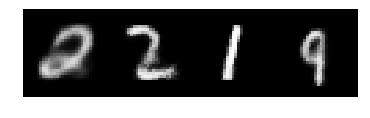

Epoch 25: Gen CE loss: 1.10 Disc CE loss 0.55 Disc acc: 0.758 Correct: 37917 Valid Loss: 106.70
Sample Z


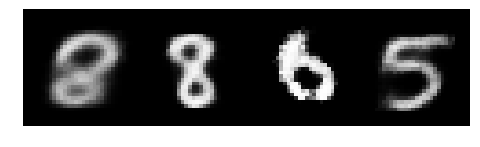

Real input


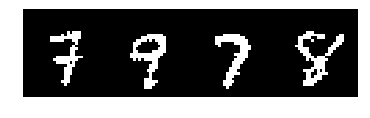

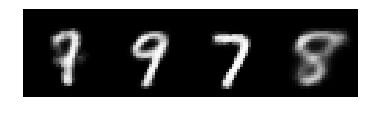

Epoch 30: Gen CE loss: 1.11 Disc CE loss 0.55 Disc acc: 0.756 Correct: 37815 Valid Loss: 106.79
Sample Z


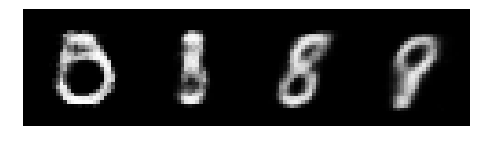

Real input


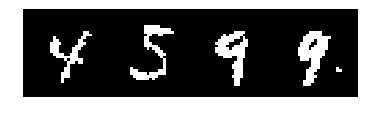

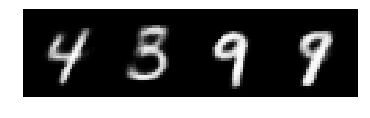

Epoch 35: Gen CE loss: 1.12 Disc CE loss 0.55 Disc acc: 0.758 Correct: 37911 Valid Loss: 106.29
Sample Z


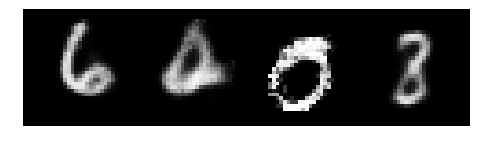

Real input


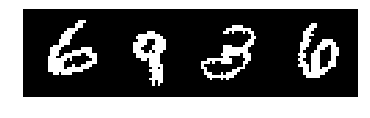

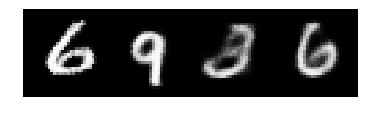

Epoch 40: Gen CE loss: 1.12 Disc CE loss 0.55 Disc acc: 0.752 Correct: 37599 Valid Loss: 107.65
Sample Z


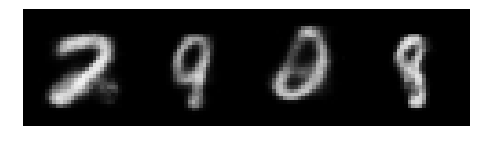

Real input


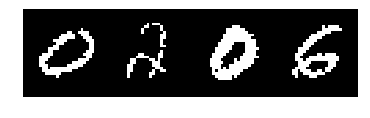

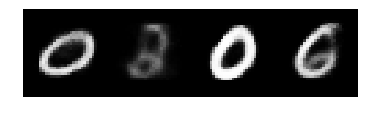

Epoch 45: Gen CE loss: 1.12 Disc CE loss 0.55 Disc acc: 0.754 Correct: 37677 Valid Loss: 107.01
Sample Z


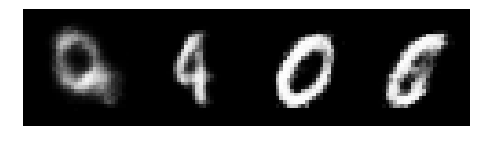

Real input


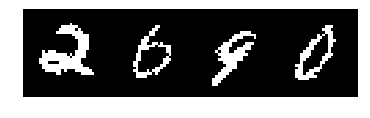

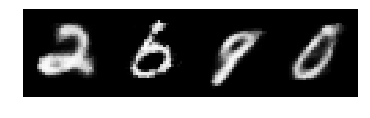

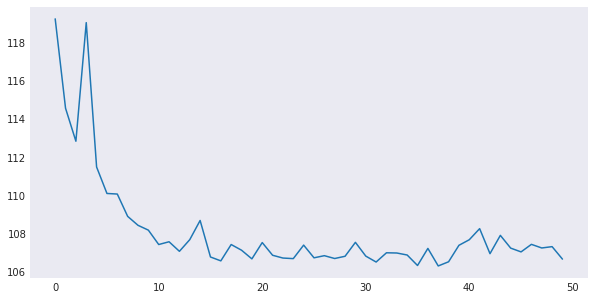

In [72]:
# Training
batch_size = 100
pre_train = 3
cuda = True
latent_dim = 6
train_interval = 100
hidden_dim = 1000
model_aae = VAE(latent_dim = latent_dim, hidden_dim = hidden_dim)
model_aae.cuda()
discrim = Discriminator()
discrim.cuda()
aae_optimizer = torch.optim.Adam(model_aae.parameters(), lr = 1e-3)
enc_optimizer = torch.optim.Adam(model_aae.encoder.parameters(), lr = 1e-3)
dis_optimizer = torch.optim.Adam(discrim.parameters(), lr = 1e-3)
aae_scheduler = MultiStepLR(aae_optimizer, milestones=[pre_train], gamma=10)
valid_losses = train_AAE(model_aae,discrim, aae_optimizer,enc_optimizer, dis_optimizer,aae_scheduler, train_loader, epochs=50)
plt.figure(figsize=(10,5))
plt.plot(valid_losses)
plt.show()

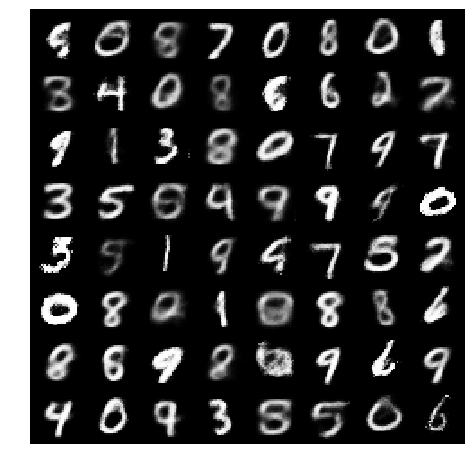

In [73]:
visualize_random_sample(model_aae,test_loader, num=64)

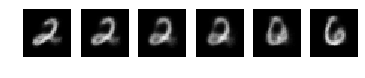

In [92]:
visualize_interpolated_samples(model_aae,test_loader)

Epoch 0: Gen CE loss: 0.00 Disc CE loss 0.00 Disc acc: 0.000 Correct: 0 Valid Loss: 159.71
Sample Z


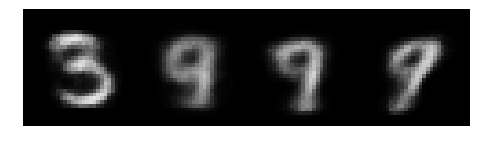

Real input


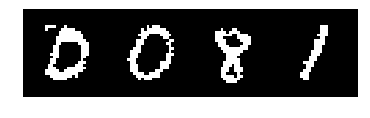

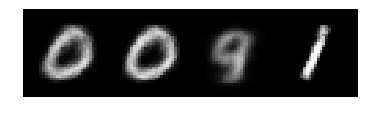

Epoch 5: Gen CE loss: 0.75 Disc CE loss 0.67 Disc acc: 0.531 Correct: 26538 Valid Loss: 152.74
Sample Z


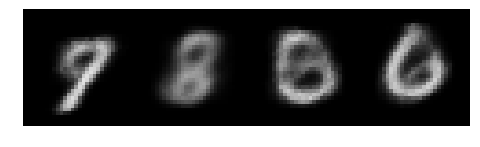

Real input


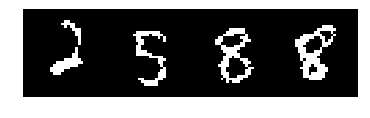

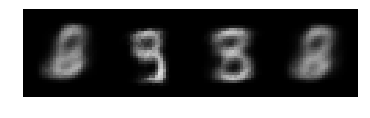

Epoch 10: Gen CE loss: 0.98 Disc CE loss 0.64 Disc acc: 0.517 Correct: 25854 Valid Loss: 149.62
Sample Z


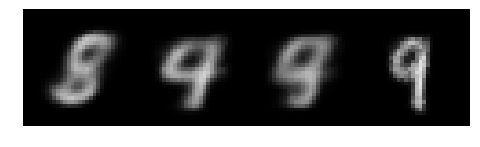

Real input


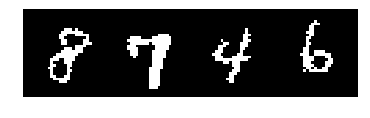

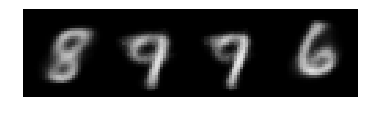

Epoch 15: Gen CE loss: 1.06 Disc CE loss 0.63 Disc acc: 0.521 Correct: 26051 Valid Loss: 149.59
Sample Z


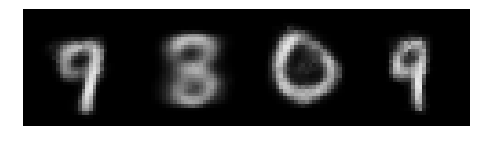

Real input


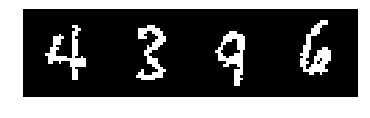

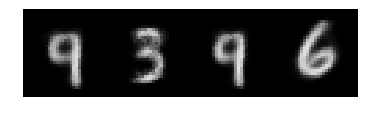

Epoch 20: Gen CE loss: 1.11 Disc CE loss 0.62 Disc acc: 0.528 Correct: 26402 Valid Loss: 149.02
Sample Z


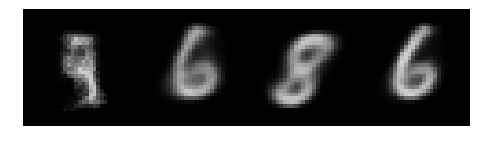

Real input


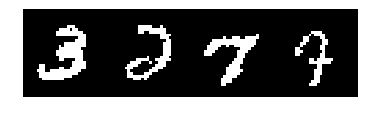

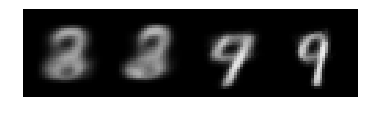

Epoch 25: Gen CE loss: 1.21 Disc CE loss 0.62 Disc acc: 0.545 Correct: 27249 Valid Loss: 148.96
Sample Z


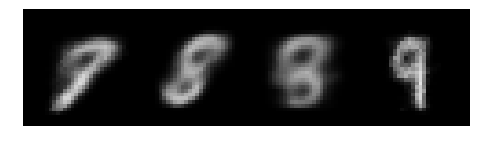

Real input


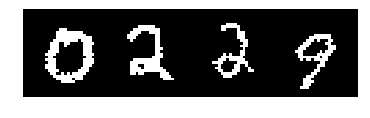

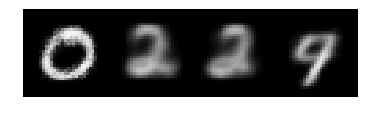

Epoch 30: Gen CE loss: 1.27 Disc CE loss 0.61 Disc acc: 0.539 Correct: 26962 Valid Loss: 149.80
Sample Z


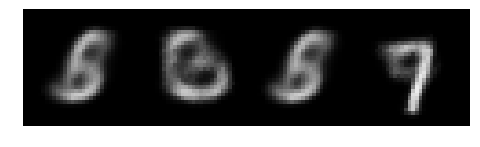

Real input


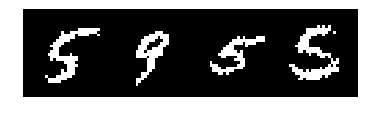

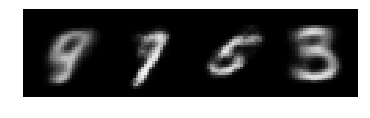

Epoch 35: Gen CE loss: 1.31 Disc CE loss 0.61 Disc acc: 0.534 Correct: 26696 Valid Loss: 148.39
Sample Z


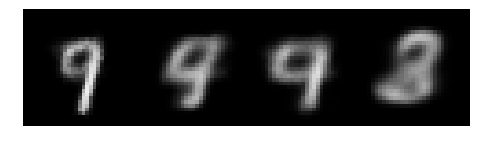

Real input


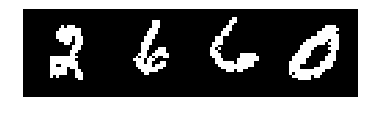

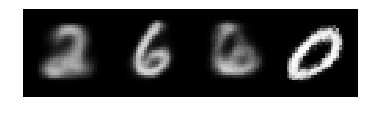

Epoch 40: Gen CE loss: 1.32 Disc CE loss 0.61 Disc acc: 0.524 Correct: 26192 Valid Loss: 148.44
Sample Z


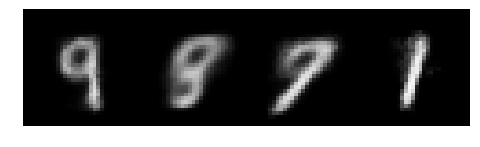

Real input


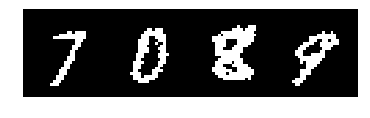

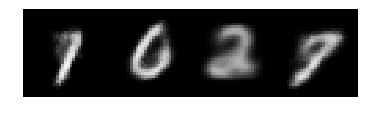

Epoch 45: Gen CE loss: 1.36 Disc CE loss 0.61 Disc acc: 0.537 Correct: 26859 Valid Loss: 148.07
Sample Z


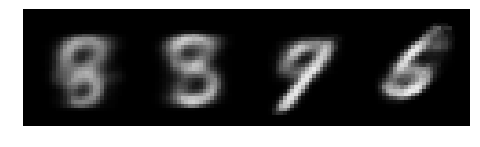

Real input


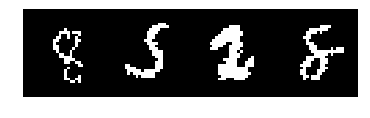

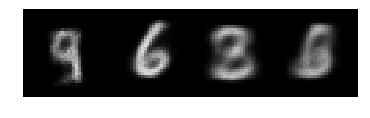

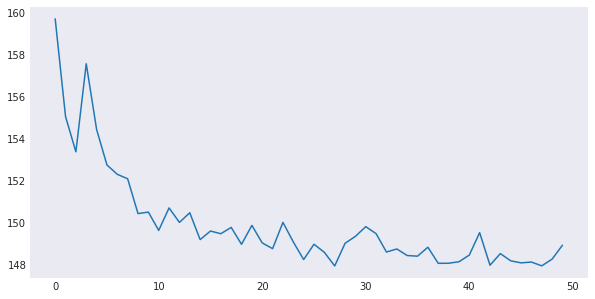

In [61]:
batch_size = 100
pre_train = 3
cuda = True
latent_dim = 2
train_interval = 100
hidden_dim = 1000
model_aae = VAE(latent_dim = latent_dim, hidden_dim = hidden_dim)
model_aae.cuda()
discrim = Discriminator()
discrim.cuda()
aae_optimizer = torch.optim.Adam(model_aae.parameters(), lr = 1e-3)
enc_optimizer = torch.optim.Adam(model_aae.encoder.parameters(), lr = 1e-3)
dis_optimizer = torch.optim.Adam(discrim.parameters(), lr = 1e-3)
aae_scheduler = MultiStepLR(aae_optimizer, milestones=[pre_train], gamma=10)
valid_losses = train_AAE(model_aae,discrim, aae_optimizer,enc_optimizer, dis_optimizer,aae_scheduler, train_loader, epochs=50)
plt.figure(figsize=(10,5))
plt.plot(valid_losses)
plt.show()

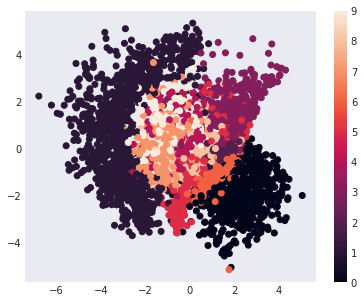

In [67]:
visualize_encoder(model_aae,test_loader)

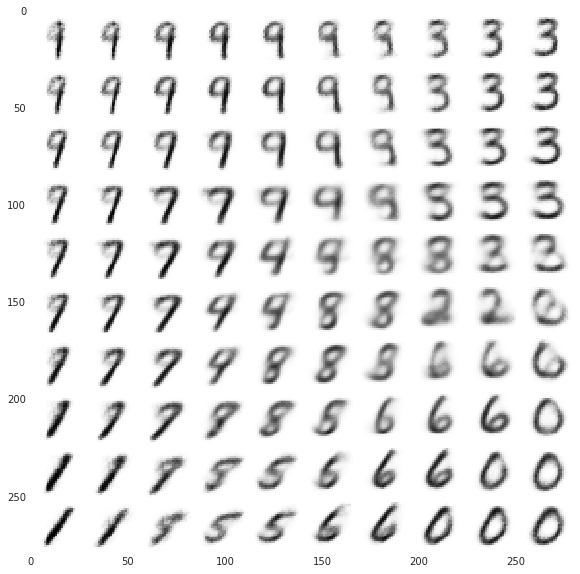

In [71]:
visualize_decoder(model_aae)